# Importações Iniciais
Nesta célula, importamos todas as bibliotecas necessárias para o processamento do texto, análise de frequência, modelagem de tópicos LDA e visualização dos resultados. `spacy` é utilizado para o processamento de linguagem natural (NLP), `gensim` para modelagem de tópicos e representação bag-of-words, `nltk` para análise de frequência e manipulação de texto, e `pyLDAvis` para a visualização interativa dos tópicos. `pandas` e `matplotlib` são usados para manipulação de dados e visualização, respectivamente.

In [183]:
import spacy
from gensim.corpora import Dictionary
import nltk
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
from itertools import chain
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer, models

from unidecode import unidecode
from gensim.models import CoherenceModel
from gensim.models import LdaModel

import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/etorebraga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/etorebraga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Habilitando a Visualização no Notebook
Com `pyLDAvis.enable_notebook()`, habilitamos a visualização interativa do LDA diretamente no Jupyter Notebook, facilitando a análise exploratória dos tópicos gerados pelo modelo.

In [2]:
pyLDAvis.enable_notebook()

# Preparação das Stopwords
Aqui, carregamos e definimos as stopwords específicas para documentos jurídicos em português. Isso inclui stopwords comuns da língua portuguesa e termos frequentes em textos legais que não contribuem significativamente para a identificação de tópicos distintos.


In [65]:
#Getting portuguese legal stopwords
nlp = spacy.load('pt_core_news_sm')

legal_stopwords = ['processo', 'lei', 'artigo', 'n', 'nº', 'nºs', 'nºs.', 'nº.', 'nºs', 'nºs.', 'nº', 'recursais', 'causa', 'data']

manual_stopwords = ['nao', '1a', 'ix', '2o', 'janeiro', 'Rio', '4o', '3o', '1o', '5o', 'rio', 'Rio de Janeiro', 'rio de janeiro', ' ']

custom_stopwords = legal_stopwords + manual_stopwords


# Leitura e Preprocessamento dos Documentos
Nesta célula, lemos os documentos a partir de um arquivo Excel e realizamos o preprocessamento. O preprocessamento inclui a remoção de acentos, a lematização dos tokens, a remoção de stopwords e pontuação, e a filtragem de tokens baseada em critérios específicos, como comprimento do token e presença na lista de stopwords personalizada.



In [66]:
preprocessed_docs = list(pd.read_excel('data_example.xlsx')[1])
preprocessed_docs [0]

'os juizes que integram a turma recursal dos juizados especiais civeis, por unanimidade, em conhecer do recurso e dar-lhe parcial provimento para reformar a sentenca e julgar procedente em parte o pedido indenizatorio para condenar o reu ao pagamento de r$ 3.000,00 (tres mil reais), a titulo de danos morais, diante da caracterizacao da ofensa a bem da personalidade do autor, atendendo ao carater punitivo, pedagogico e compensatorio, sendo a indenizacao fixada de acordo com o principio da razoabilidade e proporcionalidade, evitando-se o injusto enriquecimento, tendo sido todas as questoes aduzidas no recurso apreciadas, sendo dispensada a transcricao das conclusoes em homenagem aos principios informativos previstos no artigo 2o da lei 9099/95, e na forma do artigo 46, segunda  publicacao oficial do tribunal de justica do estado do rio de janeiro – lei federal no 11.419/2006, art. 4o e resolucao tj/oe no 10/2008.  ano 10 – no 227/2018 data de disponibilizacao: sexta-feira, 17 de agosto c

In [67]:
docs = list(pd.read_excel('data_example.xlsx')[1])

preprocessed_docs = []

for doc in docs:
    # Remove accents
    doc = unidecode(doc)
    
    parsed_doc = nlp(doc)
    preprocessed_doc = [token.lemma_ for token in parsed_doc if not token.is_stop and not token.is_punct and token.text not in custom_stopwords and not (token.is_digit and len(token.text) < 4)]
    
    preprocessed_docs.append(preprocessed_doc)

# Análise de Frequência de Tokens
Após o preprocessamento, analisamos a frequência dos tokens nos documentos para identificar potenciais stopwords adicionais e entender a distribuição de palavras no corpus.



In [68]:
# Flatten the list of lists into a single list
words = list(chain.from_iterable(preprocessed_docs))

tokens = nltk.word_tokenize(' '.join(words))

# Get the frequency distribution of the tokens
freq_dist = FreqDist(tokens)

# Display the most common 30 tokens, which could be potential stopwords
common_tokens = freq_dist.most_common(30)
print(common_tokens)

[('turma', 210), ('recurso', 209), ('.', 167), ('art', 166), ('ser', 156), ('disposto', 141), ('juiz', 137), ('recursal', 136), ('unanimidade', 134), ('conhecer', 132), ('integrar', 131), ('9099/95', 130), ('provimento', 129), ('sentenca', 106), ('civel', 104), ('federal', 103), ('principio', 99), ('prever', 97), ('resolucao', 95), ('tj', 89), ('honorario', 87), ('atender', 86), ('custa', 86), ('recorrente', 85), ('questoe', 84), ('conclusoe', 84), ('homenagem', 84), ('frisando-se', 84), ('motivacao', 84), ('concisa', 84)]


# Criação do Dicionário e do Corpus
Utilizamos o `Dictionary` do Gensim para mapear cada palavra única a um ID e filtramos palavras extremamente raras ou frequentes. Em seguida, transformamos os documentos em uma representação bag-of-words (BoW), essencial para a modelagem de tópicos LDA.

In [135]:

# Create a dictionary representation of the documents
dictionary = Dictionary(preprocessed_docs)

dictionary.filter_extremes(no_below=15, no_above=0.6)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

# Função para Calcular Coerência dos Modelos LDA
Definimos uma função para iterar sobre vários números de tópicos, treinar modelos LDA para cada configuração e calcular a coerência de cada modelo. A coerência mede a qualidade dos tópicos gerados, ajudando a escolher o número ótimo de tópicos.

In [163]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, seed=43):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=seed, alpha='auto', eta='auto', )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Cálculo da Coerência para Diferentes Números de Tópicos
Aqui, executamos a função definida anteriormente para calcular a coerência de modelos LDA com diferentes números de tópicos. Isso nos ajuda a determinar o número ideal de tópicos para o nosso modelo.

In [167]:
# Your start, limit, and step values go here
start = 5
limit = 12
step = 1

# Compute coherence values for a range of number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=preprocessed_docs, start=start, limit=limit, step=step, seed=8)

# Visualização da Coerência dos Modelos
Com esta célula, visualizamos como a coerência varia com diferentes números de tópicos, permitindo-nos escolher o modelo mais coerente.



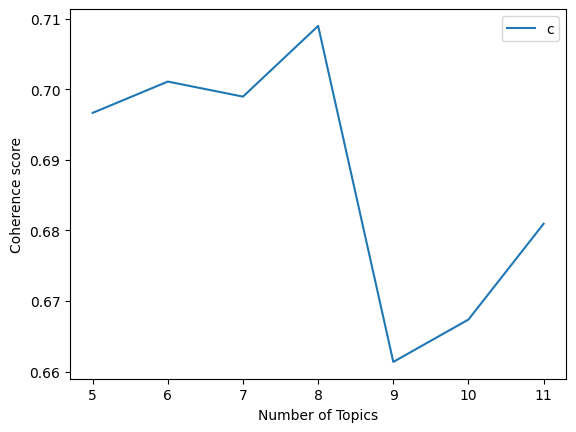

In [168]:
def plot_graph(start, limit, step, coherence_values):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


plot_graph(start, limit, step, coherence_values)
chosen_model = model_list[max(range(len(coherence_values)), key=coherence_values.__getitem__)]

# Preparação e Visualização dos Tópicos com pyLDAvis
Usando `pyLDAvis.gensim.prepare`, preparamos os dados do modelo LDA escolhido para visualização e, em seguida, exibimos a visualização interativa no notebook. Esta visualização ajuda a explorar a relação entre os tópicos e as palavras mais representativas de cada tópico.



In [169]:
pyLDAvis.gensim.prepare(chosen_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.114145  0.003656       1        1  43.276092
3      0.040106 -0.123193       2        1  18.411410
1      0.102016  0.069995       3        1  10.853514
2     -0.004693 -0.021744       4        1  10.739391
0     -0.201951  0.054235       5        1   8.175461
5      0.048032 -0.004960       6        1   4.388185
6     -0.119655 -0.056389       7        1   2.786194
7      0.022000  0.078400       8        1   1.369752, topic_info=         Term        Freq       Total Category  logprob  loglift
3     9099/95  123.000000  123.000000  Default  30.0000  30.0000
15   especial   64.000000   64.000000  Default  29.0000  29.0000
19    juizado   64.000000   64.000000  Default  28.0000  28.0000
43   conforme   60.000000   60.000000  Default  27.0000  27.0000
48      valer   65.000000   65.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
45   observar    0.594715   41.052716   Topic8  -4.1338   0.0560
52   9.099/95    0.534685   41.710385   Topic8  -4.2402  -0.0663
33  resolucao    0.926446   98.683038   Topic8  -3.6906  -0.3778
44  negar-lhe    0.583797   65.090379   Topic8  -4.1524  -0.4234
2     14/2012    0.480199   77.800933   Topic8  -4.3477  -0.7972

[319 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.426711  10/2008
0         2  0.266695  10/2008
0         3  0.106678  10/2008
0         6  0.053339  10/2008
0         7  0.106678  10/2008
...     ...       ...      ...
59        3  0.074795     voto
59        4  0.074795     voto
59        5  0.710553     voto
59        7  0.112193     voto
59        8  0.037398     voto

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1, 6, 7, 8])

# Exibição dos Tópicos e suas Palavras mais Relevantes
Listamos os tópicos gerados pelo modelo LDA escolhido, juntamente com as palavras mais relevantes para cada tópico. Isso fornece uma visão geral dos temas abordados no corpus.



In [172]:
for idx, topic in chosen_model.print_topics(-1, num_words=25):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.094*"termos" + 0.092*"relator" + 0.087*"voto" + 0.074*"publico" + 0.064*"julgamento" + 0.052*"ministerio" + 0.052*"presente" + 0.052*"fazendar" + 0.037*"negar-lhe" + 0.033*"dar ela" + 0.022*"juizado" + 0.021*"especial" + 0.016*"resolucao" + 0.015*"parcial" + 0.014*"rj" + 0.012*"regimento" + 0.012*"tj" + 0.011*"interno" + 0.011*"negar" + 0.011*"advocaticio" + 0.011*"9.099/95" + 0.010*"conformidade" + 0.010*"pagamento" + 0.010*"transcricao" + 0.010*"dispensar"
Topic: 1 
Words: 0.070*"9099/95" + 0.051*"valer" + 0.047*"negar-lhe" + 0.047*"condenar" + 0.047*"acordao" + 0.046*"sumula" + 0.045*"conforme" + 0.036*"observar" + 0.036*"especial" + 0.034*"juizado" + 0.030*"tj" + 0.030*"ter" + 0.029*"resolucao" + 0.026*"aduzir" + 0.026*"dispensar" + 0.025*"regimento" + 0.024*"rj" + 0.023*"advocaticio" + 0.023*"transcricao" + 0.023*"14/2012" + 0.023*"interno" + 0.023*"mesmo" + 0.023*"conformidade" + 0.022*"magistratura" + 0.022*"justica"
Topic: 2 
Words: 0.053*"9099/95" + 0.052*"R

# Mapeamento dos Números de Tópicos para Nomes Descritivos
Definimos um dicionário para mapear os identificadores numéricos dos tópicos para nomes descritivos mais informativos, facilitando a interpretação dos resultados.



In [175]:
# Dicionário mapeando números de tópicos para nomes descritivos
topic_names = {
    0: "Processo e Julgamento",
    1: "Procedimentos Judiciais e Sumulação",
    2: "Decisões e Indenizações Morais",
    3: "Conformidade Regulamentar e Arbitragem",
    4: "Legislação Específica e Condenações",
    5: "Sumulação e Acordos",
    6: "Publicações e Decisões de Julgamento",
    7: "Juizados Especiais e Indenizações Morais"
}

# Associação dos Documentos aos Tópicos e Criação de um DataFrame
Nesta célula, iteramos sobre os documentos, associamos cada um a seus tópicos correspondentes usando o modelo LDA e o mapeamento de nomes de tópicos, e compilamos os resultados em um DataFrame do pandas.



In [179]:
data = []

for i, doc in enumerate(corpus):
    # Obtenha os tópicos para o documento
    doc_topics = chosen_model.get_document_topics(doc)
    
    # Converte os tópicos em um dicionário, usando o mapeamento para nomes descritivos
    topic_dict = {topic_names[topic]: perc for topic, perc in doc_topics}
    
    # Adiciona os dados à lista
    data.append({'Document': i, 'Topics': topic_dict})

# Cria um DataFrame a partir da lista
df = pd.DataFrame(data)

# Exibe o DataFrame para verificar
df.head()

,Document,Topics
0,0,"{'Decisões e Indenizações Morais': 0.21756887,..."
1,1,{'Legislação Específica e Condenações': 0.9756...
2,2,{'Legislação Específica e Condenações': 0.9738...
3,3,"{'Processo e Julgamento': 0.0108223185, 'Proce..."
4,4,{'Legislação Específica e Condenações': 0.9738...


# Exportação dos Tópicos para Excel
Finalmente, exportamos o DataFrame contendo a associação de documentos a tópicos para um arquivo Excel, facilitando a análise posterior e compartilhamento dos resultados.



In [182]:
df.to_excel('topics.xlsx')